In [40]:
import os
import pandas as pd
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader

class HATXE18(Dataset):
    def __init__(self, image_files, labels_csv, transforms=None):
        self.image_files = image_files
        self.labels_csv = labels_csv
        self.transforms = transforms
        dataset = pd.read_csv(self.labels_csv)
        self.images = []
        self.labels = []

        image_list = dataset["filename"].tolist()
        for location in image_list:
            image_path = os.path.join(image_files, location)
            self.images.append(image_path)
        self.labels = dataset["head circumference (mm)"].tolist()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]
        
        if self.transforms:
            image = self.transforms(image)
        label = torch.tensor(label, dtype=torch.float32) 
        
        sample = {"image": image, "label": label} 
        return sample
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transformations = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dataset = HATXE18("/kaggle/input/hc18-grand-challenge/training_set","/kaggle/input/hc18-grand-challenge/training_set_pixel_size_and_HC.csv", transformations)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
sample = next(iter(dataloader))
print(sample["image"].shape)  
print(sample["label"].shape) 

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [41]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Testing without using the annotation first

In [42]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class HC18(nn.Module):
    def __init__(self):
        super(HC18, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=0, bias=True)  #222x222
        self.batch_norm1 = nn.BatchNorm2d(64)  
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  #111x111

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=0, bias=True)  #109x109
        self.batch_norm2 = nn.BatchNorm2d(32)  
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 54x54
        self.linear1 = nn.Linear(54 * 54 * 32, 64)
        self.batch_norm3 = nn.BatchNorm1d(64) 
        self.linear2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.batch_norm1(x) 
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1) 
        x = self.linear1(x)
        x = F.relu(x)
        x = self.batch_norm3(x)
        x = self.linear2(x)
        
        return x

HC = HC18().to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(HC.parameters(), lr=1e-4)

In [44]:
HC.train()
loss_mit = []

for epoch in range(50):
    for bath in dataloader:
        image = bath["image"].to(device)
        circum = bath["label"].to(device)
        predict = HC(image)
        optimizer.zero_grad()
        loss = loss_function(predict,circum)
        loss.backward()
        optimizer.step()
        loss_mit.append(loss.item())
    print(f"Epoch {epoch}: {loss.item()}")

Epoch 0: 29696.525390625
Epoch 1: 32815.88671875
Epoch 2: 25735.376953125
Epoch 3: 32201.958984375
Epoch 4: 26570.712890625
Epoch 5: 29061.62109375
Epoch 6: 30687.5
Epoch 7: 26089.12109375
Epoch 8: 18954.16015625
Epoch 9: 38557.63671875
Epoch 10: 31783.90234375
Epoch 11: 50609.53125
Epoch 12: 25152.4375
Epoch 13: 50647.46484375
Epoch 14: 29649.958984375
Epoch 15: 33271.33984375
Epoch 16: 33134.28515625
Epoch 17: 26488.16796875
Epoch 18: 30656.642578125
Epoch 19: 38252.3046875
Epoch 20: 28899.0546875
Epoch 21: 30458.267578125
Epoch 22: 32704.50390625
Epoch 23: 40733.953125
Epoch 24: 36881.62890625
Epoch 25: 20252.986328125
Epoch 26: 39611.1328125
Epoch 27: 23736.953125
Epoch 28: 31258.484375
Epoch 29: 17916.19140625
Epoch 30: 38239.3671875
Epoch 31: 21267.423828125
Epoch 32: 39578.546875
Epoch 33: 33960.359375
Epoch 34: 34897.94140625
Epoch 35: 24315.765625
Epoch 36: 55268.38671875
Epoch 37: 25548.115234375
Epoch 38: 37819.44140625
Epoch 39: 23210.978515625
Epoch 40: 36787.6328125
Epoch

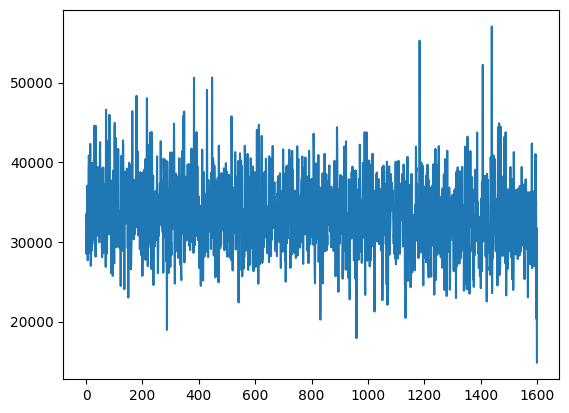

In [45]:
import matplotlib.pyplot as plt
plt.plot(loss_mit)